# ORCHIDSS Wide DDF Merging and validation

In [1]:
%matplotlib inline

# Module versions
import importlib
import sys
import time
print(time.ctime() + '\n')

print(sys.version + '\n')

for module in ['numpy', 'scipy', 'matplotlib','astropy','eazy', 'prospect']:
    #print(module)
    mod = importlib.import_module(module)
    print('{0:>20} : {1}'.format(module, mod.__version__))


Mon May 27 20:57:14 2024

3.9.7 (default, Sep 16 2021, 08:50:36) 
[Clang 10.0.0 ]

               numpy : 1.23.3
               scipy : 1.9.1
          matplotlib : 3.5.1
             astropy : 5.3.3
                eazy : 0.5.2.dev64
            prospect : 1.1.0


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, join, vstack
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.stats import bootstrap, poisson_conf_interval
from astropy.utils import NumpyRNGContext
from astropy.io import fits
from astropy.wcs import WCS

from scipy.special import erf
from scipy.special import ndtri, ndtr
from mocpy import MOC

# quiet numpy/astropy warnings
import warnings
from astropy.utils.exceptions import AstropyWarning

np.seterr(all='ignore')
warnings.simplefilter('ignore', category=AstropyWarning)

from astropy.cosmology import FlatLambdaCDM
cos = FlatLambdaCDM(H0=70, Om0=0.3)

import eazy

# Symlink templates & filters from the eazy-code repository
try:
    print('EAZYCODE = '+os.getenv('EAZYCODE'))
except:
    pass

if not os.path.exists('templates'):
    eazy.symlink_eazy_inputs() 

EAZYCODE = Users/duncan/Astro/code/eazy-py/eazy-photoz


In [3]:
def calcflux(SED, wave, filt, units):
    """ Convolve synthetic SEDs with a given filter

    Arguments
    ---------
        SED : numpy.array
            Grid of synthetic spectra
        filt : '~smpy.Filter' class
            Filter through which to convolve SED grid
        z : float
            Redshift at which models are to be observed
        dl : '~astropy.units.Quantity'
            Luminosity distance corresponding to redshift(z) in given
            cosmology.
        units : '~astropy.units'
            Desired output flux units (in spectral flux density)

    Returns
    -------
        Flux : '~astropy.units.Quantity'
            Spectral flux density, with exact units as given by 'units'

    """
    # Find SED wavelength entries within filter range
    wff = np.logical_and(filt.wave[0] < wave,
                         wave < filt.wave[-1])
    wft = wave[wff]

    # Interpolate to find throughput values at new wavelength points
    tpt = griddata(filt.wave, filt.response, wft)

    # Join arrays and sort w.r.t to wf
    # Also replace units stripped by concatenate
    wf = np.array(np.concatenate((filt.wave, wft))) * u.AA
    tp = np.concatenate((filt.response, tpt))

    order = np.argsort(wf)
    wf = wf[order]
    tp = tp[order]

    # Interpolate redshifted SED and LyAbs at new wavelength points
    sed = griddata(wave, SED.T, wf).T * SED.unit
    #lyabs = griddata(wave, self.lyman_abs, wf)

    # Calculate f_nu mean
    # Integrate SED through filter, as per BC03 Fortran
    # As: f_nu=int(dnu Fnu Rnu/h*nu)/int(dnu Rnu/h*nu)
    # ie: f_nu=int(dlm Flm Rlm lm / c)/int(dlm Rlm/lm)
    top = np.trapz(sed * tp * wf /
                   c.c.to(u.AA / u.s), wf)
    bottom = np.trapz(tp / wf, wf)
    #area = (4 * np.pi * (dl ** 2))
    Flux = top / bottom #/ (1 + z) / area

    return Flux.to(units)

def calcStats(photoz, specz):
    cut = np.logical_and(photoz >= 0, specz > 0.00)
    print('NGD: {0}'.format(cut.sum()))
    dz = photoz - specz

    ol1 = (np.abs(dz)/(1+specz) > 0.2)
    nmad = 1.48 * np.median( np.abs(dz[cut] - np.median(dz[cut])) / (1+specz[cut]))
    ol2 = (np.abs(dz)/(1+specz) > 5*nmad )
    OLF1 = np.sum( ol1[cut] ) / float(len(dz[cut]))
    OLF2 = np.sum( ol2[cut] ) / float(len(dz[cut]))

    print('NMAD: {0:.4f}'.format(nmad))
    print('Bias: {0:.4f}'.format(np.nanmedian(dz[cut]/(1+specz[cut]))))
    print('Bias: {0:.4f}'.format(np.nanmedian(dz[cut])))
    print('OLF: Def1 = {0:.4f} Def2 = {1:0.4f}'.format(OLF1, OLF2))
    print('\n')

    ol1_s, ol2_s = np.invert(ol1), np.invert(ol2)

    return ol1_s, ol2_s, np.nanmedian(dz[ol1_s]/(1+specz[ol1_s]))

def pbelowz(zphot, zerr, zcut):
    dz = zphot - zcut
    sigma_abs = (np.abs(dz)/zerr)

    psigma_abs = ndtr(sigma_abs)
    
    psigma = np.copy(psigma_abs)
    psigma[dz > 0.] = 1-psigma_abs[dz > 0.]
    
    return psigma


In [4]:
catalogues = []
sps_cats = []
areas = []

for field in ['WD02', 'WD03', 'WD10']:
    main_cat = Table.read(f'../TargetCatalogues/ORCHIDSSwide-ddf_{field}_20240527.fits')
    sps_cat = Table.read(f'../TargetCatalogues/ORCHIDSSwide-ddf_{field}_20240527_sps_outputs.fits')
    
    moc = MOC.load(f'../TargetCatalogues/ORCHIDSSwide-ddf_{field}_MOC.fits')
    
    areas.append((moc.sky_fraction*4*np.pi*u.steradian).to(u.deg**2))
    
    uv_col =  -2.5*np.log10(sps_cat['restU']/sps_cat['restV'])
    vj_col =  -2.5*np.log10(sps_cat['restV']/sps_cat['restJ'])

    passive = (uv_col > (0.88*vj_col + 0.79)) * (uv_col > 1.3) * (vj_col < 1.6)

    Mb = 23.9 - 2.5*np.log10(sps_cat['restB']) - (cos.distmod(main_cat['REDSHIFT_ESTIMATE']).value -2.5*(np.log10(1+main_cat['REDSHIFT_ESTIMATE'])))
    #Mb_st_z = -21 + -1.03*(xmm_eazy_input['z_spec'] - 0.5)
    
    sps_cat['U_V'] = uv_col
    sps_cat['V_J'] = vj_col
    sps_cat['Passive'] = passive
    sps_cat['Mb'] = Mb
    
    catalogues.append(main_cat)
    sps_cats.append(sps_cat)

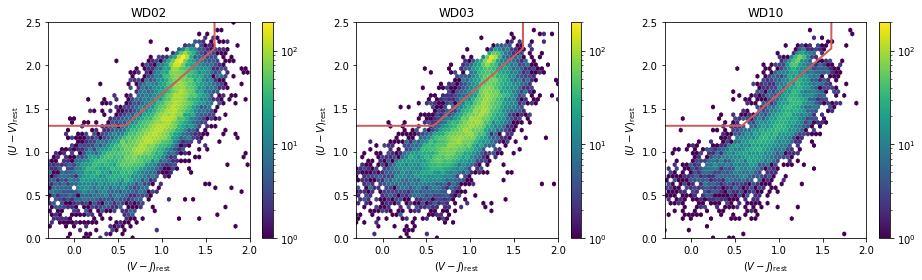

In [5]:
Fig, Ax = plt.subplots(1, 3, figsize=(13,4))

for i, field in enumerate(['WD02', 'WD03', 'WD10']):
    cat = sps_cats[i]

    Hx1= Ax[i].hexbin(cat['V_J'], cat['U_V'], 
              bins='log', extent=[-0.3, 2.0, 0, 2.5], 
                      gridsize=50, edgecolor=None, vmin=1, vmax=200)
    #Ax.plot(vj_col[passive*cut*Mb_cut], uv_col[passive*cut*Mb_cut], 'o', color='indianred', ms=1, alpha=0.1)
    Ax[i].set_xlim([0, 2.])
    Ax[i].set_ylim([0, 2.5])
    Ax[i].set_title(f'{field}')
    Cb1 = Fig.colorbar(Hx1, ax=Ax[i])

for ax in Ax:
    ax.set_xlim([-0.3, 2.])
    ax.set_ylim([0, 2.5])
    ax.set_xlabel(r'$(V-J)_{\rm{rest}}$')
    ax.set_ylabel(r'$(U-V)_{\rm{rest}}$')
    ax.plot([-0.5, 0.58, 1.6, 1.6], [1.3, 1.3, 2.198, 2.5], color='indianred', lw=2)

Fig.tight_layout()
# Fig.savefig('orchidss_wide_UVJ_comparison.pdf')

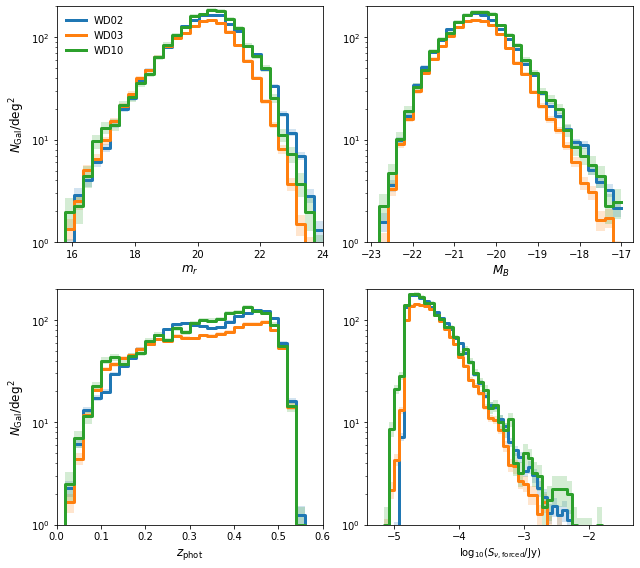

In [6]:
Fig, Ax = plt.subplots(2,2,figsize=(9, 8))

Ax = Ax.flatten()

for i, field in enumerate(['WD02', 'WD03', 'WD10']):
    cat = catalogues[i]
    sps = sps_cats[i]
    
    counts, bins = np.histogram(cat['MAG'], bins=30, range=(15.5, 24))
    plow, phigh = poisson_conf_interval(counts)
    
    Ax[0].fill_between(bins[1:], phigh/areas[i], plow/areas[i], alpha=0.2, step='pre')
    Ax[0].step(bins[1:], counts/areas[i], where='pre', lw=3, 
            label=f'{field}')
    
    counts, bins = np.histogram(sps['Mb'], bins=30, range=(-23, -17))
    plow, phigh = poisson_conf_interval(counts)
    
    Ax[1].fill_between(bins[1:], phigh/areas[i], plow/areas[i], alpha=0.2, step='pre')
    Ax[1].step(bins[1:], counts/areas[i], where='pre', lw=3, 
            label=f'{field}')
    
    counts, bins = np.histogram(cat['REDSHIFT_ESTIMATE'], bins=30, range=(0, 0.6))
    plow, phigh = poisson_conf_interval(counts)
    
    Ax[2].fill_between(bins[1:], phigh/areas[i], plow/areas[i], alpha=0.2, step='pre')
    Ax[2].step(bins[1:], counts/areas[i], where='pre', lw=3, 
            label=f'{field}')
    
    counts, bins = np.histogram(np.log10(cat['Peak_flux_forced']), bins=50, range=(-5.3, -1.5))
    plow, phigh = poisson_conf_interval(counts)
    
    Ax[3].fill_between(bins[1:], phigh/areas[i], plow/areas[i], alpha=0.2, step='pre')
    Ax[3].step(bins[1:], counts/areas[i], where='pre', lw=3, 
            label=f'{field}')
    
    #Ax.hist(mag_r[optical_selection], bins=50, histtype='step', lw=3, label='Optical Selection', range=(15.5, 24))

    Leg = Ax[0].legend(loc='upper left', frameon=False)

Ax[0].set_xlabel(r'$m_{r}$', size=12)
Ax[0].set_ylabel(r'$N_{\rm{Gal}} / \rm{deg}^{2}$', size=12)
Ax[0].set_xlim([15.5, 24.])
Ax[1].set_xlabel('$M_{B}$', size=12)
Ax[2].set_xlim([0, 0.6])
Ax[2].set_xlabel(r'$z_{\rm{phot}}$', size=12)
Ax[2].set_ylabel(r'$N_{\rm{Gal}} / \rm{deg}^{2}$', size=12)
Ax[3].set_xlabel(r'$\log_{10}(S_{\nu, \rm{forced}}/\rm{Jy})$')

for ax in Ax:
    ax.set_yscale('log')
    ax.set_ylim([1, 200])

Fig.tight_layout()

#Fig.savefig('orchidss_wide_optical_magdist.pdf', format='pdf')

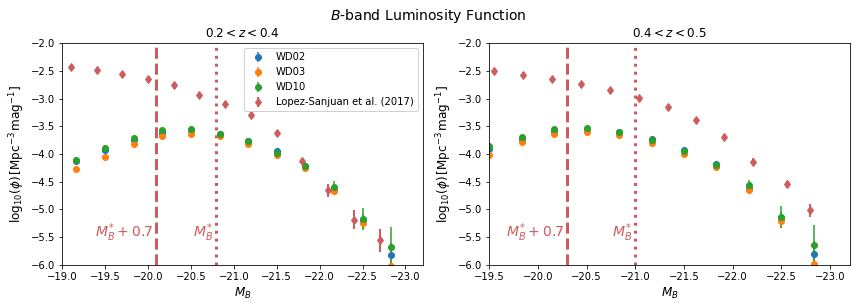

In [7]:
ls_lf = """−24.5	−23.0	−23.29	−7.05 ± 0.34	−23.42	−6.39 ± 0.26	−23.20	−5.75 ± 0.14	−23.34	−5.45 ± 0.09
            −23.0	−22.7	−22.79	−5.56 ± 0.21	−22.81	−5.02 ± 0.11	−22.82	−4.64 ± 0.06	−22.83	−4.44 ± 0.05
            −22.7	−22.4	−22.56	−5.19 ± 0.17	−22.54	−4.55 ± 0.07	−22.52	−4.18 ± 0.05	−22.53	−3.99 ± 0.04
            −22.4	−22.1	−22.21	−4.66 ± 0.11	−22.22	−4.14 ± 0.06	−22.23	−3.83 ± 0.04	−22.23	−3.59 ± 0.03
            −22.1	−21.8	−21.91	−4.13 ± 0.06	−21.93	−3.70 ± 0.04	−21.93	−3.51 ± 0.03	−21.94	−3.27 ± 0.02
            −21.8	−21.5	−21.62	−3.63 ± 0.05	−21.63	−3.38 ± 0.03	−21.64	−3.23 ± 0.02	−21.64	−3.08 ± 0.02
            −21.5	−21.2	−21.34	−3.30 ± 0.04	−21.34	−3.15 ± 0.03	−21.34	−3.03 ± 0.02	−21.34	−2.90 ± 0.02
            −21.2	−20.9	−21.04	−3.10 ± 0.03	−21.04	−2.99 ± 0.02	−21.04	−2.87 ± 0.02	−21.04	−2.76 ± 0.01
            −20.9	−20.6	−20.74	−2.94 ± 0.03	−20.74	−2.85 ± 0.02	−20.74	−2.75 ± 0.02	−20.75	−2.64 ± 0.01
            −20.6	−20.3	−20.44	−2.76 ± 0.03	−20.45	−2.74 ± 0.02	−20.45	−2.65 ± 0.01	−20.45	−2.56 ± 0.01
            −20.3	−20.0	−20.15	−2.65 ± 0.02	−20.15	−2.65 ± 0.02	−20.15	−2.58 ± 0.01	−20.15	−2.47 ± 0.01
            −20.0	−19.7	−19.85	−2.56 ± 0.02	−19.84	−2.58 ± 0.02	−19.85	−2.50 ± 0.01	−19.85	−2.42 ± 0.01
            −19.7	−19.4	−19.55	−2.48 ± 0.02	−19.55	−2.50 ± 0.02	−19.55	−2.45 ± 0.01	−19.56	−2.36 ± 0.01
            −19.4	−19.1	−19.25	−2.43 ± 0.02	−19.25	−2.45 ± 0.01	−19.25	−2.41 ± 0.01	−19.27	−2.34 ± 0.02
            −19.1	−18.8	−18.95	−2.38 ± 0.02	−18.95	−2.39 ± 0.01	−18.95	−2.37 ± 0.01	−19.02	−2.30 ± 0.03
            −18.8	−18.5	−18.65	−2.32 ± 0.02	−18.65	−2.33 ± 0.01	−18.67	−2.37 ± 0.01	···	···
            −18.5	−18.2	−18.35	−2.27 ± 0.02	−18.35	−2.29 ± 0.01	−18.42	−2.34 ± 0.03	···	···
            −18.2	−17.9	−18.05	−2.22 ± 0.02	−18.06	−2.23 ± 0.02	···	···	···	···
            −17.9	−17.6	−17.75	−2.17 ± 0.02	−17.76	−2.18 ± 0.02	···	···	···	···
            −17.6	−17.3	−17.45	−2.12 ± 0.01	−17.49	−2.17 ± 0.03	···	···	···	···
            −17.3	−17.0	−17.16	−2.06 ± 0.02	···	···	···	···	···	···
            −17.0	−16.7	−16.86	−2.01 ± 0.02	···	···	···	···	···	···
            −16.7	−16.4	−16.56	−1.98 ± 0.02	···	···	···	···	···	···
            −16.4	−16.1	−16.26	−1.92 ± 0.03	···	···	···	···	···	···
            −16.1	−15.8	−15.97	−1.87 ± 0.04	···	···	···	···	···	···
            −15.8	−15.5	−15.69	−1.83 ± 0.07	···	···	···	···	···	···"""

# LS17
arr = np.array([line.split('\t') for line in ls_lf.split('\n')])
ls_binmids = -1*np.array([np.float32(d.strip('−')) for d in arr[:-6, 1]], dtype='float32')
ls_nd = -1*np.array([np.float32(d.split(' ± ')[0].strip('−')) for d in arr[:-6, 3]], dtype='float32')
ls_nderr = np.array([np.float32(d.split(' ± ')[1].strip('−')) for d in arr[:-6, 3]], dtype='float32')

Fig, Ax = plt.subplots(1, 2, figsize=(12, 4.5))

for i, field in enumerate(['WD02', 'WD03', 'WD10']):
    cat = catalogues[i]
    sps = sps_cats[i]
    zbin = (cat['REDSHIFT_ESTIMATE'] > 0.2) * (cat['REDSHIFT_ESTIMATE'] < 0.4)
    volume = areas[i].to(u.steradian)/4*np.pi*u.steradian * (cos.comoving_volume(0.4) - cos.comoving_volume(0.2))

    counts, bins = np.histogram(sps['Mb'], range=[-23, -19], bins=12)

    binmids = 0.5*(bins[:-1]+bins[1:])

    nd = np.log10(counts/volume.value/np.diff(bins))
    nderr = 2.5*np.log10(np.e)*(np.sqrt(counts)/counts)

    Ax[0].errorbar(binmids, nd, yerr=nderr, fmt='o', label=f'{field}')

Ax[0].errorbar(ls_binmids, ls_nd, yerr=ls_nderr, fmt='d', color='indianred', elinewidth=2, 
         label='Lopez-Sanjuan et al. (2017)')

Ax[0].set_xlim([-19., -23.2])
Ax[0].set_ylim([-6, -2])
Ax[0].set_title('$0.2 < z < 0.4$', size=12)
Ax[0].set_xlabel(r'$M_{B}$', size=12)
Ax[0].set_ylabel(r'$\log_{10}(\phi)\/[\rm{Mpc}^{-3}\/\rm{mag}^{-1}$]', size=12)

Ax[0].vlines(-21 + -1.03*(0.3 - 0.5), ymax=-2, ymin=-6, ls=':', color='indianred', lw=3)
Ax[0].vlines(-21 + -1.03*(0.3 - 0.5)+0.7, ymax=-2, ymin=-6, ls='--', color='indianred', lw=3)
Ax[0].text(-21 + -1.03*(0.3 - 0.5)+0.03, -5.5, r'$M_{B}^{*}$', color='indianred', size=14, ha='right')
Ax[0].text(-21 + -1.03*(0.3 - 0.5)+0.73, -5.5, r'$M_{B}^{*}+0.7$', color='indianred', size=14, ha='right')

leg = Ax[0].legend(loc='upper right', frameon=True, facecolor='white', framealpha=0.9)


# ### Bin 2
for i, field in enumerate(['WD02', 'WD03', 'WD10']):
    cat = catalogues[i]
    sps = sps_cats[i]
    zbin = (cat['REDSHIFT_ESTIMATE'] > 0.4) * (cat['REDSHIFT_ESTIMATE'] < 0.5)
    volume = areas[i].to(u.steradian)/4*np.pi*u.steradian * (cos.comoving_volume(0.5) - cos.comoving_volume(0.4))

    counts, bins = np.histogram(sps['Mb'], range=[-23, -19], bins=12)

    binmids = 0.5*(bins[:-1]+bins[1:])

    nd = np.log10(counts/volume.value/np.diff(bins))
    nderr = 2.5*np.log10(np.e)*(np.sqrt(counts)/counts)

    Ax[1].errorbar(binmids, nd, yerr=nderr, fmt='o', label=f'{field}')

# # LS17
arr = np.array([line.split('\t') for line in ls_lf.split('\n')])
ls_binmids = -1*np.array([np.float32(d.strip('−')) for d in arr[:-6, 2]], dtype='float32')
ls_nd = -1*np.array([np.float32(d.split(' ± ')[0].strip('−')) for d in arr[:-6, 5]], dtype='float32')
ls_nderr = np.array([np.float32(d.split(' ± ')[1].strip('−')) for d in arr[:-6, 5]], dtype='float32')

Ax[1].errorbar(ls_binmids, ls_nd, yerr=ls_nderr, fmt='d', color='indianred', 
             elinewidth=2, label='Lopez-Sanjuan et al. (2017)')

Ax[1].set_xlim([-19.5, -23.2])
Ax[1].set_ylim([-6, -2])
Ax[1].set_title('$0.4 < z < 0.5$', size=12)
Ax[1].set_xlabel(r'$M_{B}$', size=12)
Ax[1].set_ylabel(r'$\log_{10}(\phi)\/[\rm{Mpc}^{-3}\/\rm{mag}^{-1}$]', size=12)

Ax[1].vlines(-21 + -1.03*(0.5 - 0.5), ymax=-2, ymin=-6, ls=':', color='indianred', lw=3)
Ax[1].vlines(-21 + -1.03*(0.5 - 0.5)+0.7, ymax=-2, ymin=-6, ls='--', color='indianred', lw=3)
Ax[1].text(-21 + -1.03*(0.5 - 0.5)+0.03, -5.5, r'$M_{B}^{*}$', color='indianred', size=14, ha='right')
Ax[1].text(-21 + -1.03*(0.5 - 0.5)+0.73, -5.5, r'$M_{B}^{*}+0.7$', color='indianred', size=14, ha='right')

Fig.suptitle('$B$-band Luminosity Function', size=14, y=0.94)
Fig.tight_layout()

In [8]:
combined_owide_ddf = vstack(catalogues)
combined_owide_ddf.write('../TargetCatalogues/ORCHIDSSwide-ddf_all_20240527.fits', overwrite=True)